In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import datetime

In [40]:
nifty = pd.read_csv('ind_nifty50list.csv')
nse = nifty.Symbol.tolist()
investment = 1000000

# Benchmark on Nifty 50

In [3]:
def getLink(t):
    period1 = int(time.mktime(datetime.datetime(2020, 10, 1, 23, 59).timetuple()))
    period2 = int(time.mktime(datetime.datetime(2022, 10, 28, 23, 59).timetuple()))
    interval = '1d'
    t = (t + '.NS') if t in nse else t

    link = f'https://query1.finance.yahoo.com/v7/finance/download/{t}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
    return link

In [4]:
def getAlloc(invest, num_stocks):
    return invest/num_stocks

In [5]:
def getDv(t, alloc):
    df = pd.read_csv(getLink(t))[['Open', 'Close']]
    df['Qty'] = alloc/df.Open[0]
    df['Dv'] = df.Close * df.Qty
    return np.array(df.Dv.tolist())

In [6]:
alloc = getAlloc(1000000, len(nse))
summ = np.zeros(getDv(nse[0], alloc).shape[0])
for t in nse:
    summ = summ.copy() + getDv(t, alloc)

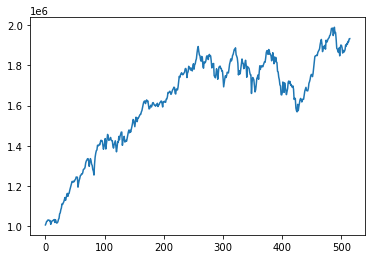

In [7]:
plt.plot(summ)

# Past Returns based Selection

In [8]:
def getP(t):
    period1 = int(time.mktime(datetime.datetime(2019, 10, 1, 23, 59).timetuple()))
    period2 = int(time.mktime(datetime.datetime(2020, 9, 30, 23, 59).timetuple()))
    interval = '1d'

    link = f'https://query1.finance.yahoo.com/v7/finance/download/{t}.NS?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
    df = pd.read_csv(link)
    c100 = df.tail(100).reset_index(drop=True).Close.tolist()
    close_lastday = c100[-1]
    close_100day_before_last_day = c100[0]
    perform_value = (close_lastday/close_100day_before_last_day)-1
    return perform_value

In [9]:
p = []
for t in nse:
    perf = getP(t)
    p.append([t, perf])

In [10]:
df_p = pd.DataFrame(p, columns=["Comp", "Perf"])

In [11]:
top10 = df_p.sort_values(by=["Perf"], ascending=False).reset_index(drop=True).Comp.tolist()[:10]
print(top10)

['ADANIENT', 'APOLLOHOSP', 'WIPRO', 'EICHERMOT', 'HCLTECH', 'TATAMOTORS', 'JSWSTEEL', 'BAJFINANCE', 'RELIANCE', 'M&M']


In [12]:
alloc = getAlloc(1000000, len(top10))
summ10 = np.zeros(getDv(nse[0], alloc).shape[0])
for t in top10:
    summ10 = summ10.copy() + getDv(t, alloc)

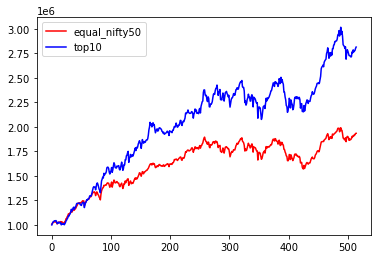

In [13]:
plt.plot(summ, color="red", label="equal_nifty50")
plt.plot(summ10, color="blue", label="top10")
plt.legend()

# Nifty Index Equity Curve

In [14]:
nifty50 = getDv("%5ENSEI", 1000000)

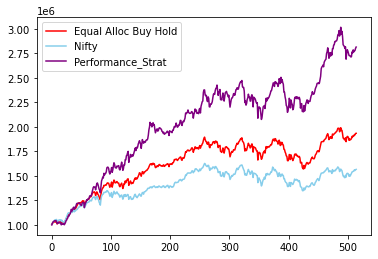

In [15]:
plt.plot(summ, color="red", label="Equal Alloc Buy Hold")
plt.plot(nifty50, color="skyblue", label="Nifty")
plt.plot(summ10, color="purple", label="Performance_Strat")
plt.legend()

# Performance Metrics

In [48]:
def getDr(arr):
    ans = [0]
    for i in range(1, len(arr)):
        r = (arr[i]/arr[i-1])-1
        try:
            int(r)
            ans.append(r)
        except:
            ans.append(0)
    return np.array(ans)

In [49]:
def cagr(arr, t):
    r = arr[-1]/investment
    r = r**(1/t)
    return r

In [60]:
t = datetime.datetime(2020, 10, 1, 23, 59)-datetime.datetime(2022, 10, 28, 23, 59)
t = abs(t.days)

In [61]:
def voltality(arr):
    dr = getDr(arr)
    r = dr.std()**(1/252)
    r = r*100
    return r

In [62]:
def sharperatio(arr):
    dr = getDr(arr)
    r = (dr.mean()/dr.std())**(1/252)
    r = r*100
    return r

In [63]:
def getp(arr):
    return [cagr(arr, t), voltality(arr), sharperatio(arr)]

In [64]:
a = [summ, nifty50, summ10]
ans = []
for i in a:
    ans.append(getp(i))

In [73]:
df = pd.DataFrame(ans, columns=["CAGR", "Voltality", "Sharpe"])
df.index = ["Equal Alloc Buy Hold", "Nifty", "Performance_Strat"]
df

,CAGR,Voltality,Sharpe
Equal Alloc Buy Hold,1.000871,98.238483,99.154345
Nifty,1.000592,98.207880,99.027056
Performance_Strat,1.001368,98.352023,99.223782
